In [35]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, torch_wrapper
from scipy.sparse.linalg import eigsh
import scipy.sparse as sp
from scipy.special import expit, logit

import scprep
from geomloss import SamplesLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
adata = sc.read_h5ad("ebdata_v3.h5ad")
adata

AnnData object with n_obs × n_vars = 18203 × 17789
    obs: 'sample_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'dpt_pseudotime', '1d-phate', '1d-phate-normalized'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_name', 'gene_id', 'gene_name_id'
    uns: 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'sample_labels_colors', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_phate', 'X_phate_normalized', 'X_phate_real_time', 'X_phate_time', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

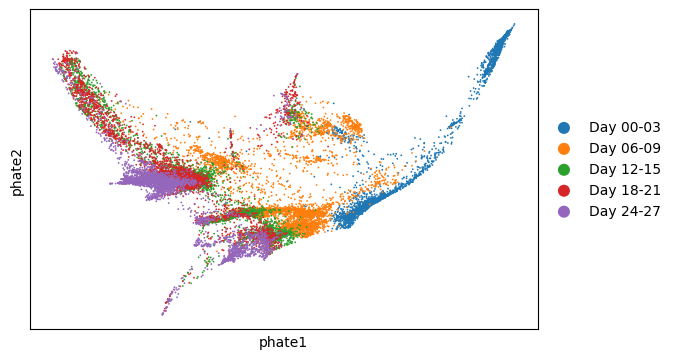

<Figure size 600x400 with 0 Axes>

In [37]:
from matplotlib import rcParams

FIGSIZE = (6,4)
rcParams["figure.figsize"] = FIGSIZE
ax = sc.pl.scatter(adata, basis="phate", color="sample_labels", title="")
plt.savefig("phate_plot.png", dpi=300)

In [38]:
A = adata.obsp["connectivities"].toarray()
L = np.diag(A.sum(0)) - A

In [39]:
n_times = len(adata.obs["sample_labels"].unique())
# Standardize coordinates
coords = adata.obsm["X_phate"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_phate_standardized"] = coords
X = [
    adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == t]
    for t in range(n_times)
]

#### load the learned data 

In [ ]:
sde = 'tbm'
stage = 1
folder_forw = f"../../results/single_cell/sb/{sde}/stage{stage}-forward.npy"
with open(folder_forw, "rb") as f:
    forward = np.load(f)

In [41]:
sample_id = 0
time_id = -1
sample_steps = np.linspace(0, 99, 100).astype(int)
sample_id = 0
x = forward[sample_id,sample_steps,:]
n_obs = adata.shape[0]
n_obs_per_label = [X[t].shape[0] for t in range(n_times)]
b = np.cumsum(n_obs_per_label)
y2 = np.zeros(n_obs)

for t in range(n_times):
    if t==0:
        y2[x[time_id].argsort()[-b[t]:]] = t
    else:
        y2[x[time_id].argsort()[-b[t]:-b[t-1]]] = t

In [42]:
for t in range(1,n_times):
    if t==0:
        y2[x[time_id].argsort()[-b[t]:]] = t
    else:
        y2[x[time_id].argsort()[-b[t]:-b[t-1]]] = t
# compute hit rate
accuracy = np.zeros(n_times)
for t in range(n_times):
    idx = np.where(y2 == t)[0]
    idx_true = np.where(adata.obs["sample_labels"].cat.codes == t)[0]
    accuracy[t] = len(np.intersect1d(idx, idx_true)) / len(idx_true)
    
    print(f"Accuracy at timepoint {t}: {accuracy[t]:.2f}")

Accuracy at timepoint 0: 0.95
Accuracy at timepoint 1: 0.74
Accuracy at timepoint 2: 0.38
Accuracy at timepoint 3: 0.48
Accuracy at timepoint 4: 0.72


In [43]:
loss_1 = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
loss_2 = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

x0 = adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == 4, 0]
x1 = adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == 4, 1]
x_true = torch.tensor(np.stack([x0, x1], axis=1)).float()

y0 = adata.obsm["X_phate_standardized"][y2 == 4, 0]
y1 = adata.obsm["X_phate_standardized"][y2 == 4, 1]
x_pred = torch.tensor(np.stack([y0, y1], axis=1)).float()

L1 = (loss_1(x_true, x_pred)).item()  
L2 = torch.sqrt(loss_2(x_true, x_pred)).item()  
print(L1, L2)
    

0.23092374205589294 0.4166278839111328


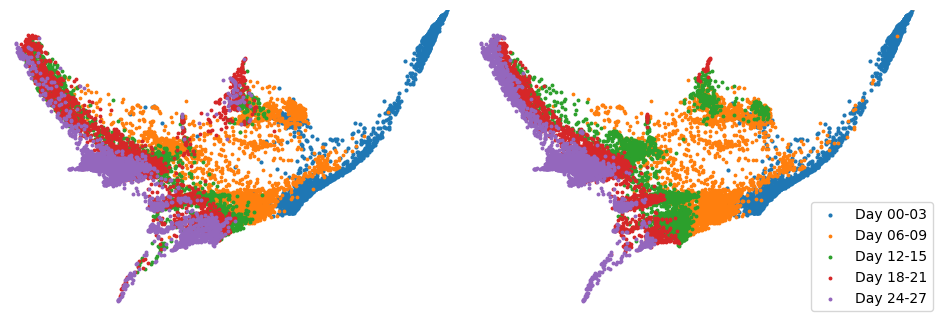

In [44]:
f, axes = plt.subplots(1,2, figsize=(12, 4))
for t in range(n_times):
    plot_original(t, axes[0])
    plot_reconstructed(t, axes[1])
    
for ax in axes.flatten():  # In case of a grid of subplots
    ax.set_xlim(-2, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

axes[1].legend(adata.obs["sample_labels"].cat.categories, fontsize=10)
plt.subplots_adjust(wspace=0)


In [45]:
def plot_original(label, ax):
    scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == label, 0],
    adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == label, 1],
    ax=ax,
    legend=None,
)
    
def plot_reconstructed(label, ax): 
    scprep.plot.scatter(
    adata.obsm["X_phate_standardized"][y2==label, 0],
    adata.obsm["X_phate_standardized"][y2==label, 1],
    ax=ax,
    legend=None,
)